In [ ]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

In [2]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import string
import ast

import re
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
df=pd.read_csv("data/10_K_with_paragraphs.csv")

In [4]:
df.dropna(inplace=True)

In [5]:
df = df[~df['paragraphs'].apply(lambda x: x == '[]')]

### statistical analysis, you can skip that

In [5]:
df['paragraphs'] = df['paragraphs'].apply(ast.literal_eval)

In [6]:
df=df[df['paragraphs'].map(len) > 0]

In [7]:
df["len"]=df['paragraphs'].apply(lambda x : len(x))

<Axes: ylabel='Frequency'>

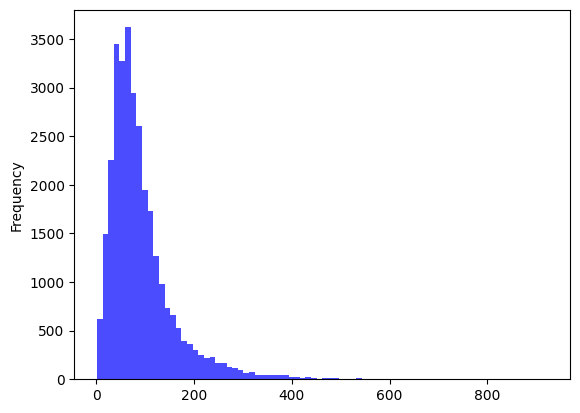

In [8]:
df["len"].plot(kind='hist', bins=80, alpha=0.7, color='blue')

In [9]:
df

,date,filingDate,url,cik,ticker,paragraphs,len
1,2023,2023-01-31,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,[ PART I ITEM 1.\tBUSINESS Overview We design...,47
2,2022,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,[ PART I ITEM 1.\tBUSINESS Overview We design...,50
3,2021,2021-02-08,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"[BUSINESS Overview We design, develop, manufac...",82
4,2020,2020-02-13,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"[BUSINESS Overview We design, develop, manuf...",101
5,2019,2019-02-19,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"[BUSINESS Overview We design, develop, manuf...",108
...,...,...,...,...,...,...,...
51739,2023,2023-02-24,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ Although we base these forward-looking stat...,74
51740,2022,2022-03-31,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ The mounting threat landscape has accelerat...,71
51741,2021,2021-03-23,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ Although we base these forward-looking stat...,51
51742,2020,2020-04-17,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ CAUTIONARY STATEMENT REGARDING FORWARD-LOOK...,42


<Axes: ylabel='Frequency'>

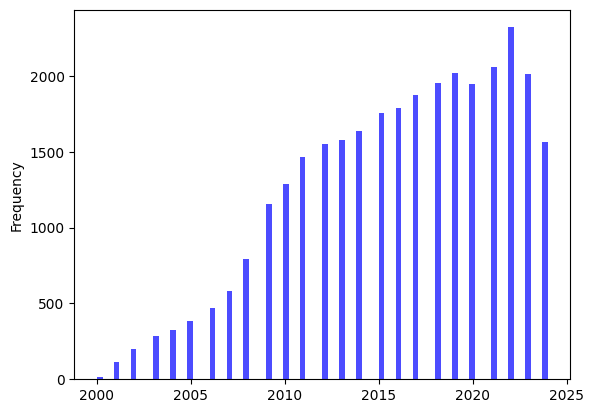

In [10]:
df["date"].plot(kind='hist', bins=80, alpha=0.7, color='blue')

In [11]:
df["len_docs"] = df["paragraphs"].apply(lambda x: [len(doc) for doc in x])
df["len_docs_max"]=df["len_docs"].apply(lambda x: np.max(np.array(x)))

<Axes: ylabel='Frequency'>

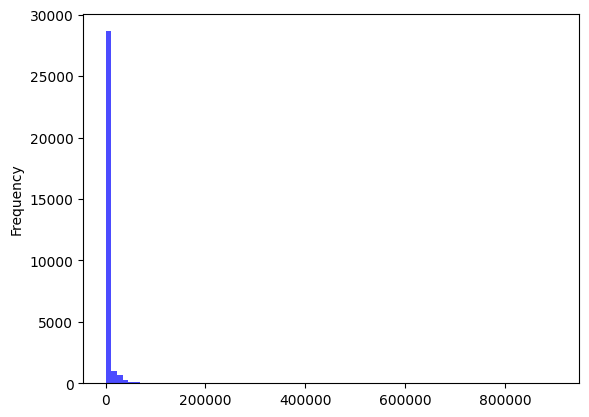

In [12]:
df["len_docs_max"].plot(kind='hist', bins=80, alpha=0.7, color='blue')

In [ ]:
array_test=df["len_docs_max"].values
array_test=np.sort(array_test)
print(array_test[-100:])
print("")
print(array_test[int(array_test.shape[0]*0.91)])

del array_test

In [14]:
df.drop(columns=["len","len_docs","len_docs_max"],inplace=True)

In [15]:
df

,date,filingDate,url,cik,ticker,paragraphs
0,2023,2023-01-31,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,[ PART I ITEM 1.\tBUSINESS Overview We design...
1,2022,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,[ PART I ITEM 1.\tBUSINESS Overview We design...
2,2021,2021-02-08,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"[BUSINESS Overview We design, develop, manufac..."
3,2020,2020-02-13,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"[BUSINESS Overview We design, develop, manuf..."
4,2019,2019-02-19,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"[BUSINESS Overview We design, develop, manuf..."
...,...,...,...,...,...,...
31124,2023,2023-02-24,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ Although we base these forward-looking stat...
31125,2022,2022-03-31,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ The mounting threat landscape has accelerat...
31126,2021,2021-03-23,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ Although we base these forward-looking stat...
31127,2020,2020-04-17,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,[ CAUTIONARY STATEMENT REGARDING FORWARD-LOOK...


### Tokenizer

In [3]:
df=pd.read_csv("data/10_K_with_paragraphs.csv")
df.dropna(inplace=True)
df = df[~df['paragraphs'].apply(lambda x: x == '[]')]
df = df.reset_index(drop=True)

In [4]:
display(df)

,date,filingDate,url,cik,ticker,paragraphs
0,2023,2023-01-31,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,['\xa0 PART I ITEM 1.\tBUSINESS Overview We de...
1,2022,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,['\xa0 PART I ITEM 1.\tBUSINESS Overview We de...
2,2021,2021-02-08,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"['BUSINESS Overview We design, develop, manufa..."
3,2020,2020-02-13,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"['BUSINESS \xa0 Overview We design, develop, m..."
4,2019,2019-02-19,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,"['BUSINESS \xa0 Overview We design, develop, m..."
...,...,...,...,...,...,...
31124,2023,2023-02-24,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,['\xa0 Although we base these forward-looking ...
31125,2022,2022-03-31,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,['\xa0 The mounting threat landscape has accel...
31126,2021,2021-03-23,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,['\xa0 Although we base these forward-looking ...
31127,2020,2020-04-17,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,['\xa0 CAUTIONARY STATEMENT REGARDING FORWARD-...


In [5]:
def clean_tokens(tokens):
    """
    Filters out tokens that are purely numerical or do not contain any letters.
    """
    return [token for token in tokens if re.search(r'[a-zA-Z]', token) and not token.isdigit()]

def split_large_paragraph(paragraph, max_length=5000):
    """
    Splits a large paragraph into smaller chunks where each chunk is less than max_length characters.
    The splits are done at sentence boundaries (periods).
    """
    # Tokenize paragraph into sentences
    sentences = sent_tokenize(paragraph) #give a list of sentences
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        # If adding the sentence exceeds the max_length, save the current chunk and start a new one
        if len(current_chunk) + len(sentence) + 1 > max_length:
            chunks.append(current_chunk.strip())
            current_chunk = sentence
        else:
            current_chunk += " " + sentence
    
    # Add the last chunk
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

def tokenizer(paragraphs, max_length=10000):
    # Tokenize and clean the documents
    untagged_data = []
    
    for i, paragraph in enumerate(paragraphs):
        # Replace hyphens with spaces and split if paragraph exceeds max_length
        paragraph_ = paragraph.replace("-", " ")
        if len(paragraph_) > max_length:
            smaller_paragraphs = split_large_paragraph(paragraph_, 5000)
        else:
            smaller_paragraphs = [paragraph_]
        
        # Process each smaller paragraph
        for small_paragraph in smaller_paragraphs:
            tokens = word_tokenize(small_paragraph.lower())
            clean_tokens_list = clean_tokens(tokens)
            untagged_data.append(clean_tokens_list)
    
    return untagged_data

In [6]:
# Create the "paragraphs" column with None or empty string values
df["tokenized"] = None

In [7]:
# Use tqdm to create a progress bar




for i in tqdm(range(len(df)), desc="tokenizing..."):
    
        df.at[i, "tokenized"] = str(tokenizer(ast.literal_eval(df.at[i, "paragraphs"]))) #to save memory we convert the list into string
        df.at[i, "paragraphs"]=None #to spare memory, we destroy the old version
        # Save the DataFrame every 1000 steps
        if (i + 1) % 6000 == 0:
            df.to_csv("data/10_K_with_paragraphs_tokenized.csv", index=False)

        

# Optionally, save the final DataFrame after the loop completes
df.to_csv("data/10_K_with_paragraphs_tokenized.csv", index=False)
print("Final DataFrame saved.")

tokenizing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31129/31129 [56:53<00:00,  9.12it/s]


Final DataFrame saved.


In [8]:
df

,date,filingDate,url,cik,ticker,paragraphs,tokenized
0,2023,2023-01-31,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,None,"[['part', 'i', 'item', 'business', 'overview',..."
1,2022,2022-02-07,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,None,"[['part', 'i', 'item', 'business', 'overview',..."
2,2021,2021-02-08,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,None,"[['business', 'overview', 'we', 'design', 'dev..."
3,2020,2020-02-13,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,None,"[['business', 'overview', 'we', 'design', 'dev..."
4,2019,2019-02-19,https://www.sec.gov/Archives/edgar/data/131860...,1318605,TSLA,None,"[['business', 'overview', 'we', 'design', 'dev..."
...,...,...,...,...,...,...,...
31124,2023,2023-02-24,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,None,"[['although', 'we', 'base', 'these', 'forward'..."
31125,2022,2022-03-31,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,None,"[['the', 'mounting', 'threat', 'landscape', 'h..."
31126,2021,2021-03-23,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,None,"[['although', 'we', 'base', 'these', 'forward'..."
31127,2020,2020-04-17,https://www.sec.gov/Archives/edgar/data/106868...,1068689,ATDS,None,"[['cautionary', 'statement', 'regarding', 'for..."
